# nCoV-2019
<img src='https://ars.els-cdn.com/content/image/3-s2.0-B9780443073670000409-f040-001-9780443073670.jpg'>

<b>Overview:</b> <br>
Model the growth of the nCoV-2019 Corona Virus infections in mainland China and outside the mainland.

<b>Data Source:</b> <br>
https://en.m.wikipedia.org/wiki/Timeline_of_the_2019–20_Wuhan_coronavirus_outbreak <br>
http://www.nhc.gov.cn/xcs/yqtb/list_gzbd.shtml <br>
https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/ <br>
https://www.thelancet.com/pb-assets/Lancet/pdfs/S0140673620302117.pdf <br>
Clinical outcome (99 Cases)
<li> Remained in hospital 57 (58%)
<li> Discharged 31 (31%)
<li> Died 11 (11%)
<br>
https://jamanetwork.com/journals/jama/fullarticle/2761044 <br>
<li>In this single-center case series of 138 hospitalized patients with confirmed NCIP in Wuhan, China, presumed hospital-related transmission of 2019-nCoV was suspected in 41% of patients, 26% of patients received ICU care, and mortality was 4.3%.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 28 08:19:13 2020
"""
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
#import packages
import smtx_ncov as sm
import pandas as pd
import numpy as np
import xlrd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from tabulate import tabulate
from matplotlib import style
from matplotlib.pylab import rcParams
style.use('fivethirtyeight')
#style.use('ggplot')

In [2]:
df_csv=pd.read_csv(r'corona2.csv')
df_xls=pd.read_excel(r'Corona.xlsx')
#Eliminating sparse data
# df=df_xls[7:]

In [3]:
rcParams['figure.figsize'] = 25,4
df_csv.plot.scatter(x='Cases', y='Deaths', s=500)

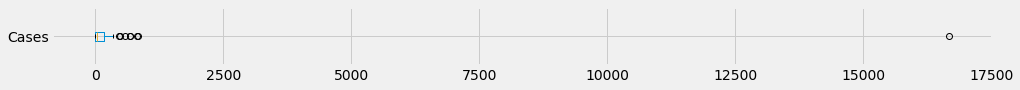

In [4]:
rcParams['figure.figsize'] =15,1
df_csv.boxplot(column='Cases', vert=False)

In [5]:
rcParams['figure.figsize'] =15,1
df_csv.boxplot(column='Deaths', vert=False)

In [6]:
df_csv_sorted = df_csv.sort_values(by='Cases', ascending=False)
print('Top 5 Regions by Cases')
df_csv_sorted.head(5)

Top 5 Regions by Cases


REGION  Cases  Deaths  \
0   Hubei province\n(including Wuhan)  16678     479   
1                   Zhejiang province    829       0   
2                  Guangdong province    813       0   
3                      Henan province    675       2   
31                        Undisclosed    675       0   

                          Notes   Links  
0   1,809 serious, 711 critical  Source  
1       43 serious, 15 critical  Source  
2       60 serious, 26 critical  Source  
3       39 serious, 15 critical  Source  
31                          NaN  Source

In [7]:
# df=df.reset_index(drop=True)

In [8]:
# df_xls=df_xls[:22]

In [9]:
rcParams['figure.figsize'] = 25,17
df_xls.plot(xticks=df_xls.index)

In [10]:
df=df_xls.fillna(0)
df['Cases_pct'] = df['Cases Confirmed'].pct_change()
df['Deaths_pct'] = df['Deaths'].pct_change()
df['Cases_new'] = df['Cases Confirmed'].diff()
df['Deaths_new'] = df['Deaths'].diff()
df

Date  Cases Suspected  Cases Confirmed  Deaths  Recovered  \
0   2019.12.31             27.0              0.0     0.0        0.0   
1   2020.01.03             44.0              0.0     0.0        0.0   
2   2020.01.05             59.0              0.0     0.0        0.0   
3   2020.01.10              0.0             41.0     1.0        0.0   
4   2020.01.11              0.0             41.0     1.0        0.0   
5   2020.01.12              0.0             41.0     1.0        0.0   
6   2020.01.13              0.0             41.0     1.0        0.0   
7   2020.01.15              0.0             41.0     2.0        7.0   
8   2020.01.16              0.0             45.0     2.0       12.0   
9   2020.01.17              0.0             62.0     2.0       15.0   
10  2020.01.18              0.0            121.0     2.0       19.0   
11  2020.01.19              0.0            198.0     3.0       25.0   
12  2020.01.20             54.0            291.0     6.0       25.0   
13  2020.01.21             37.0            440.0     9.0       25.0   
14  2020.01.22            257.0            571.0    17.0       25.0   
15  2020.01.23           1072.0            830.0    25.0       34.0   
16  2020.01.24           1965.0           1287.0    41.0       38.0   
17  2020.01.25           2684.0           1975.0    56.0       49.0   
18  2020.01.26           5794.0           2744.0    80.0       51.0   
19  2020.01.27           6973.0           4515.0   106.0       60.0   
20  2020.01.28           9239.0           5974.0   132.0      103.0   
21  2020.01.29          12167.0           7711.0   170.0      124.0   
22  2020.01.30          15238.0           9692.0   213.0      171.0   
23  2020.01.31          17988.0          11791.0   259.0      243.0   
24  2020.02.01          19544.0          14380.0   304.0      328.0   
25  2020.02.02          21558.0          17205.0   361.0      475.0   
26  2020.02.03          23214.0          20468.0   426.0      632.0   
27  2020.02.04          23260.0          24324.0   490.0      892.0   
28  2020.02.05          24702.0          28018.0   563.0     1153.0   
29  2020.02.06          26359.0          31211.0   637.0     1542.0   
30  2020.02.07          27657.0          34568.0   722.0     2050.0   

    Quarantined  Quarantined & Released     Total    Source  \
0           0.0                     0.0       0.0       [3]   
1         121.0                     0.0       0.0       [4]   
2         163.0                     0.0       0.0       [5]   
3         163.0                     0.0       0.0       [6]   
4         717.0                    46.0     763.0       [7]   
5         687.0                    76.0     763.0       [8]   
6         576.0                   187.0     763.0       [9]   
7         119.0                   644.0     763.0      [10]   
8          98.0                   665.0     763.0      [11]   
9          82.0                   681.0     763.0      [12]   
10         82.0                   681.0     763.0         0   
11         90.0                   727.0     817.0      [13]   
12        922.0                   817.0    1739.0  [14][15]   
13       1394.0                   765.0    2159.0      [16]   
14       4928.0                   969.0    5897.0      [17]   
15       8420.0                  1087.0    9507.0      [18]   
16      13967.0                  1230.0   15197.0      [19]   
17      23431.0                   325.0   23756.0      [20]   
18      32799.0                   583.0   30453.0         0   
19      44132.0                   914.0   47833.0         0   
20      59990.0                  1604.0   65537.0         0   
21      81947.0                  2364.0   88693.0         0   
22     102427.0                  2364.0  113579.0         0   
23     118478.0                  6509.0  136987.0         0   
24     137594.0                  8044.0  163844.0         0   
25          0.0                     0.0       0.0         0   
26          0.0                     

CONFIRMED CASES - Comparison


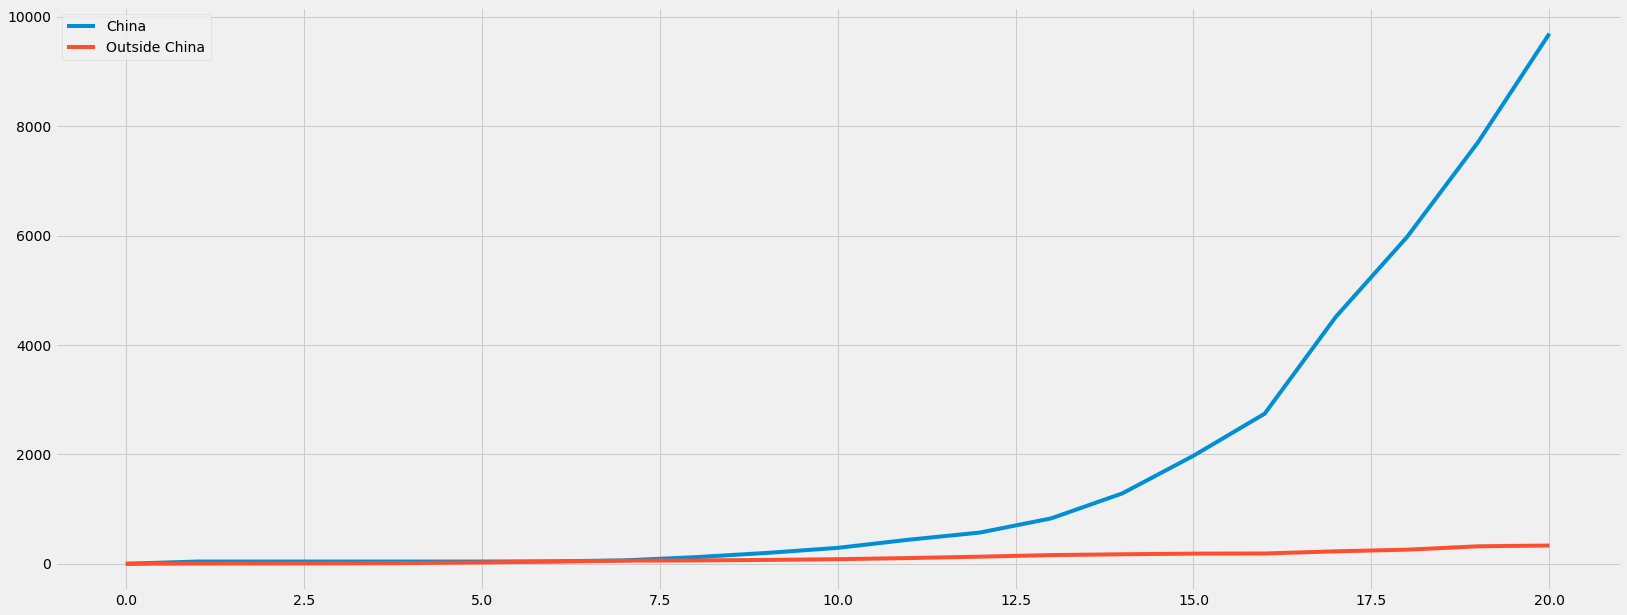

CONFIRMED CASES - Comparison of First 10 Days


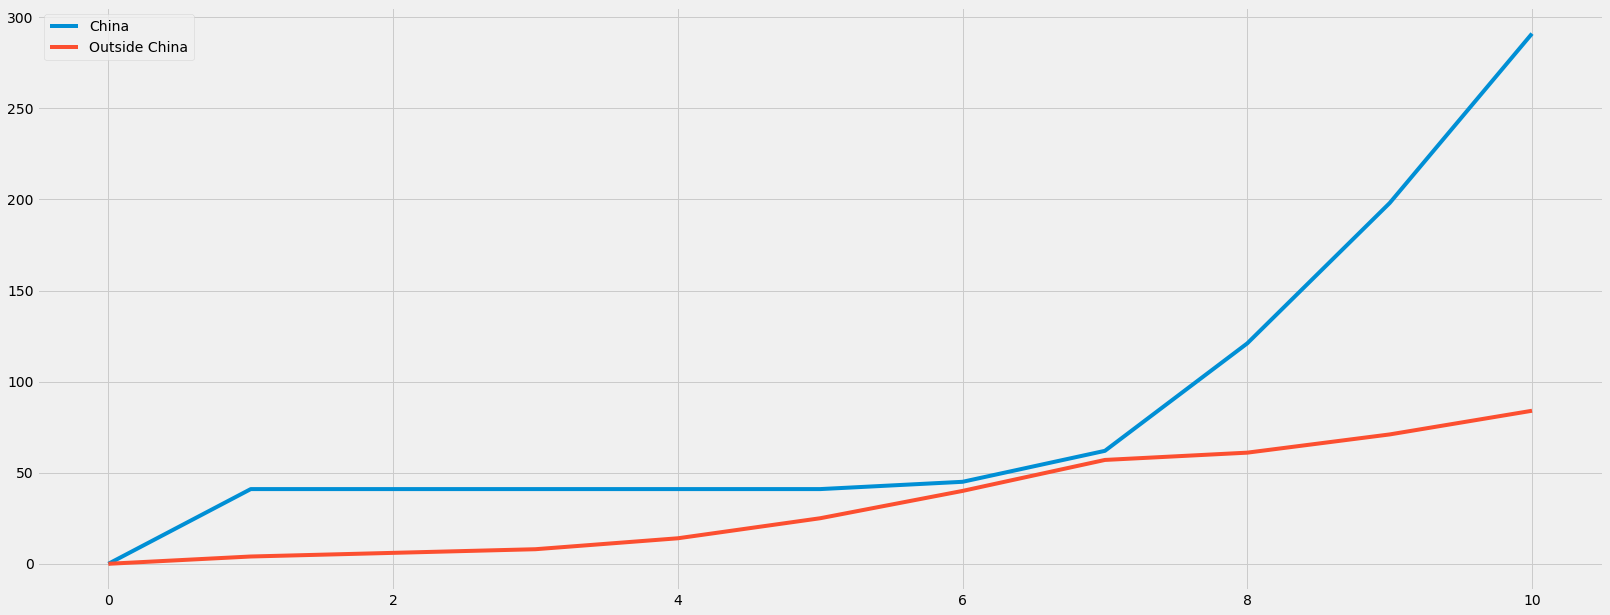

In [11]:
df_sc = df['Cases Suspected']
df_cc = df['Cases Confirmed']
df_cco = df['Cases Confirm Outside China']
print('CONFIRMED CASES - Comparison')
cco = np.array(df_cco[10:])
no_of_items = (np.size(cco))
cc = np.array(df_cc[2:(no_of_items+2)])
rcParams['figure.figsize'] = 25,10
plt.plot(cc, label = 'China')
plt.plot(cco, label = 'Outside China')
plt.legend()
plt.show()
print('CONFIRMED CASES - Comparison of First 10 Days')
cco = np.array(df_cco[10:21])
cc = np.array(df_cc[2:13])
rcParams['figure.figsize'] = 25,10
plt.plot(cc, label = 'China')
plt.plot(cco, label = 'Outside China')
plt.legend()
plt.show()

Percentage of cases outside China
*********************************
Current percentage = 1.0%


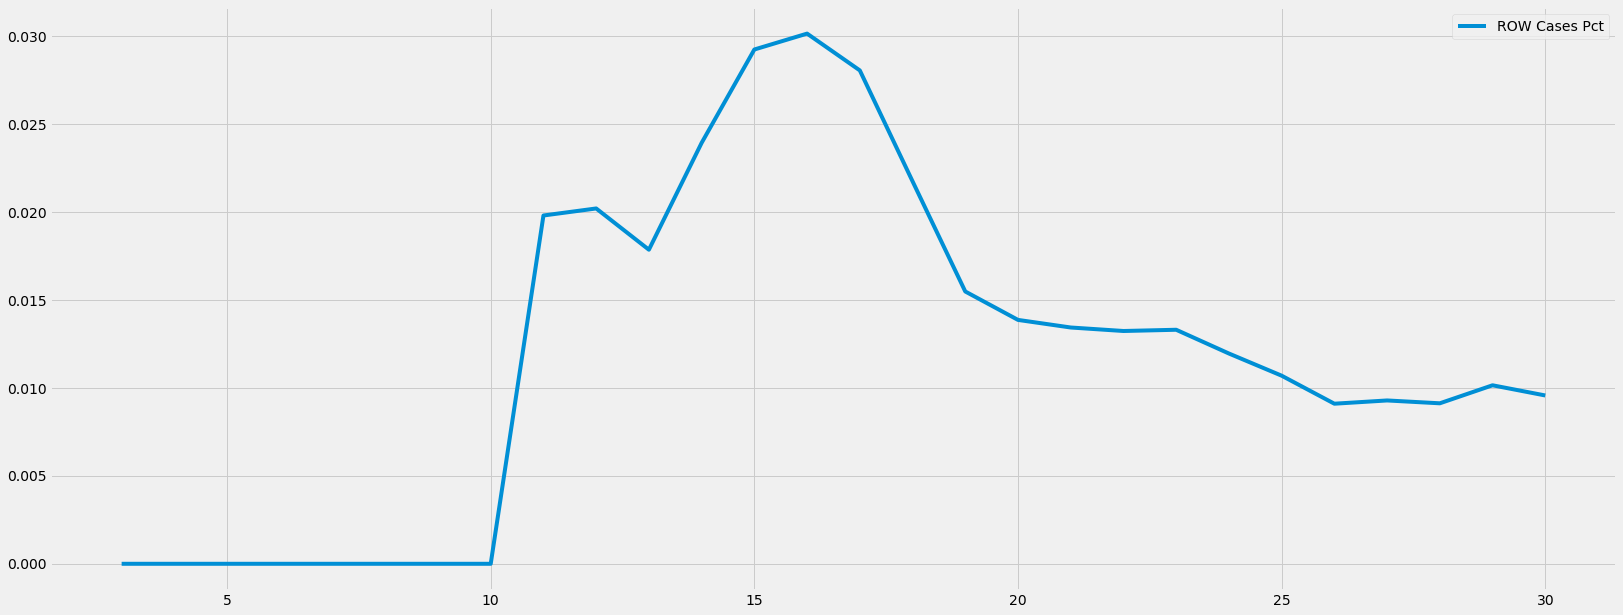

In [12]:
print('Percentage of cases outside China')
print('*********************************')
df['Total Cases'] = df['Cases Confirmed']+df['Cases Confirm Outside China']
df['China Cases Pct'] = df['Cases Confirmed']/df['Total Cases']
df['ROW Cases Pct'] = df['Cases Confirm Outside China']/df['Total Cases']
row_ratio = df['ROW Cases Pct'].tail(1).values[0]
print('Current percentage = {:0.1%}'.format(row_ratio))
df['ROW Cases Pct'].plot()
plt.legend()
plt.show()

RECOVERIES vs. FATALITIES


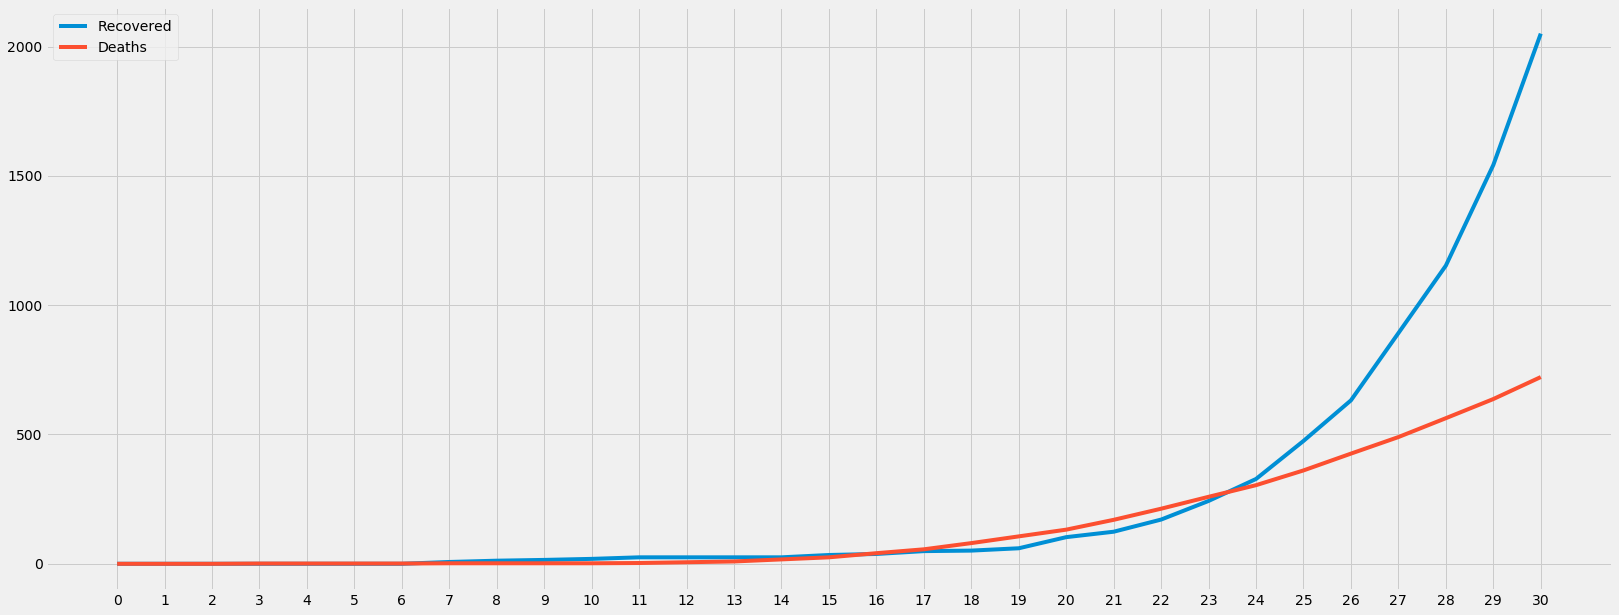

In [13]:
df_d = df['Deaths']
df_r = df['Recovered']
print('RECOVERIES vs. FATALITIES')
df_r.plot(xticks=df.index)
df_d.plot(xticks=df.index)
plt.legend()
plt.show()

Suspected CASES
***************
a =  1989.0042110183667
b =  0.09627897796610868
c =  -4183.65940574908
R^2 = 0.9471
Next predicted data point   35,158
         7 Days from Now    73,004
        14 Days from Now    147,256


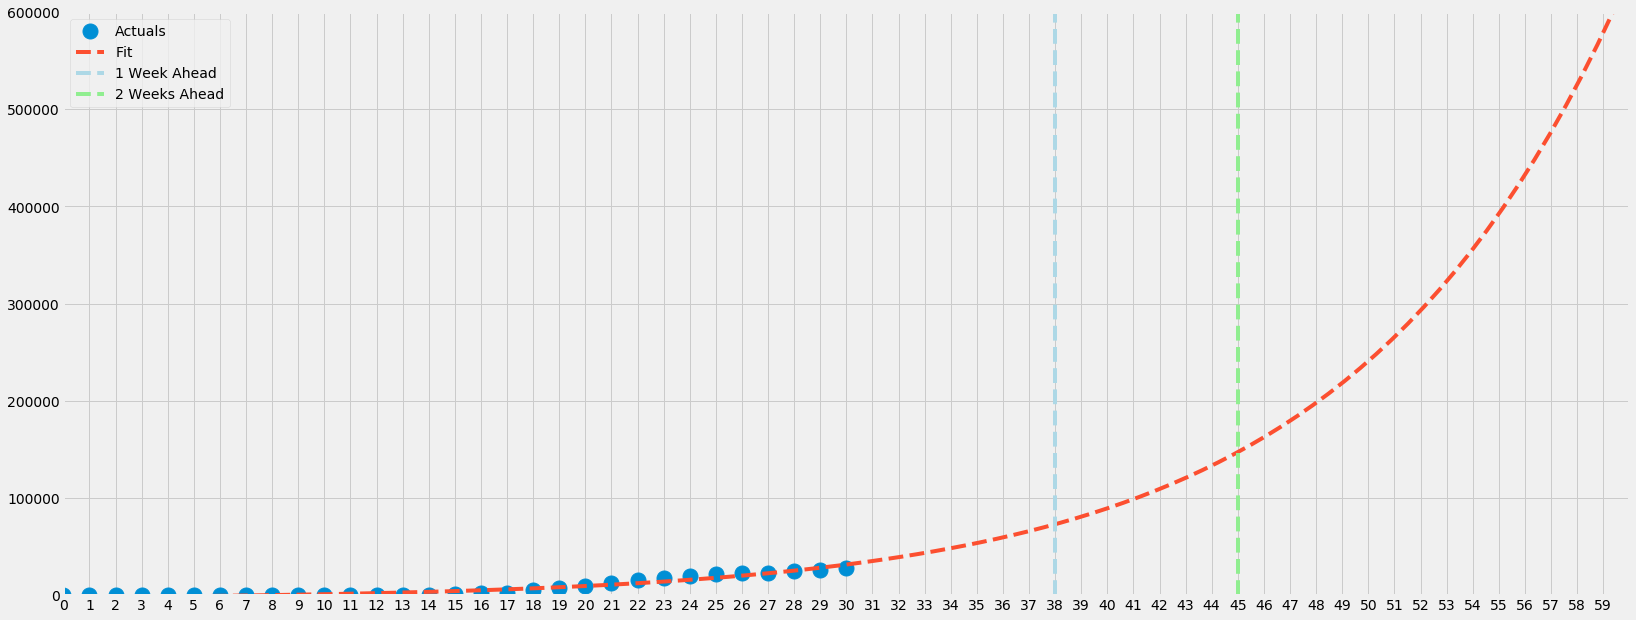

Suspected CASES
***************
a =  1989.0042110183667
b =  0.09627897796610868
c =  -4183.65940574908
R^2 = 0.9471
Next predicted data point   35,158
         7 Days from Now    73,004
        14 Days from Now    147,256


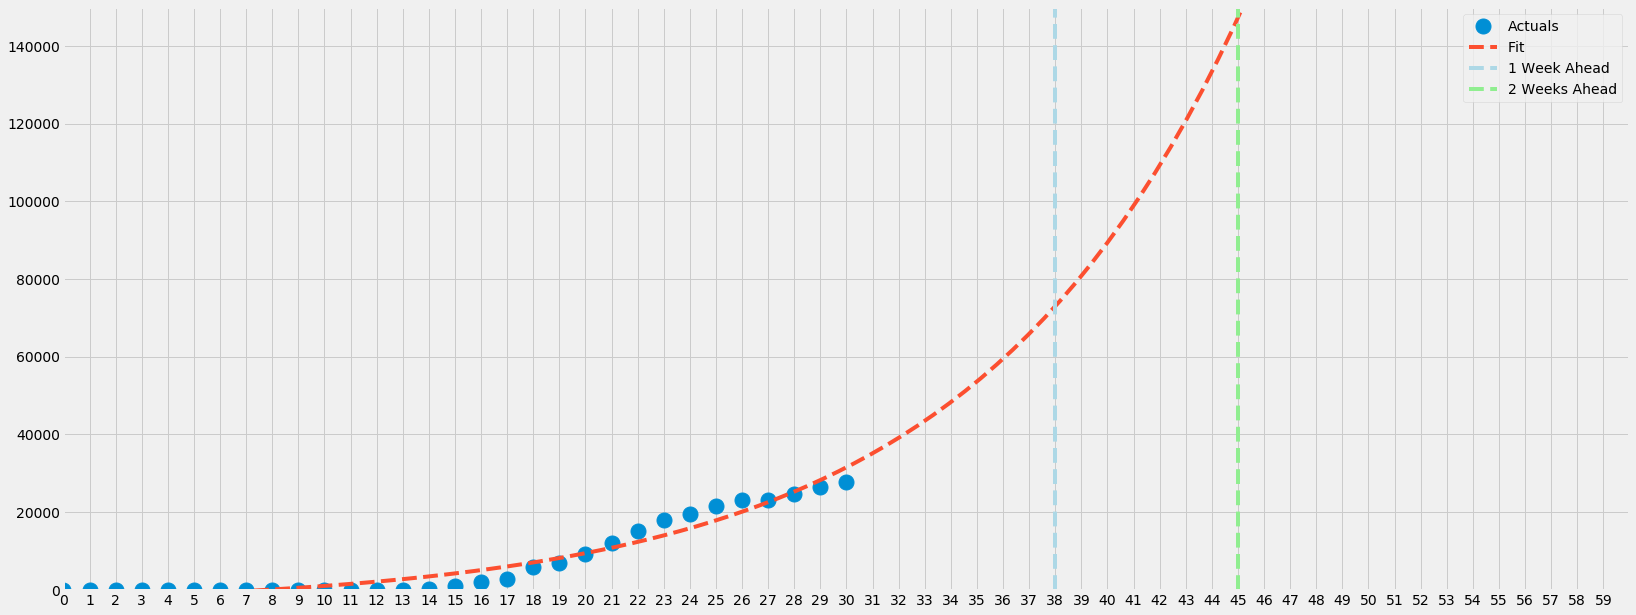

Suspected CASES
***************
a =  1989.0042110183667
b =  0.09627897796610868
c =  -4183.65940574908
R^2 = 0.9471
Next predicted data point   35,158
         7 Days from Now    73,004
        14 Days from Now    147,256


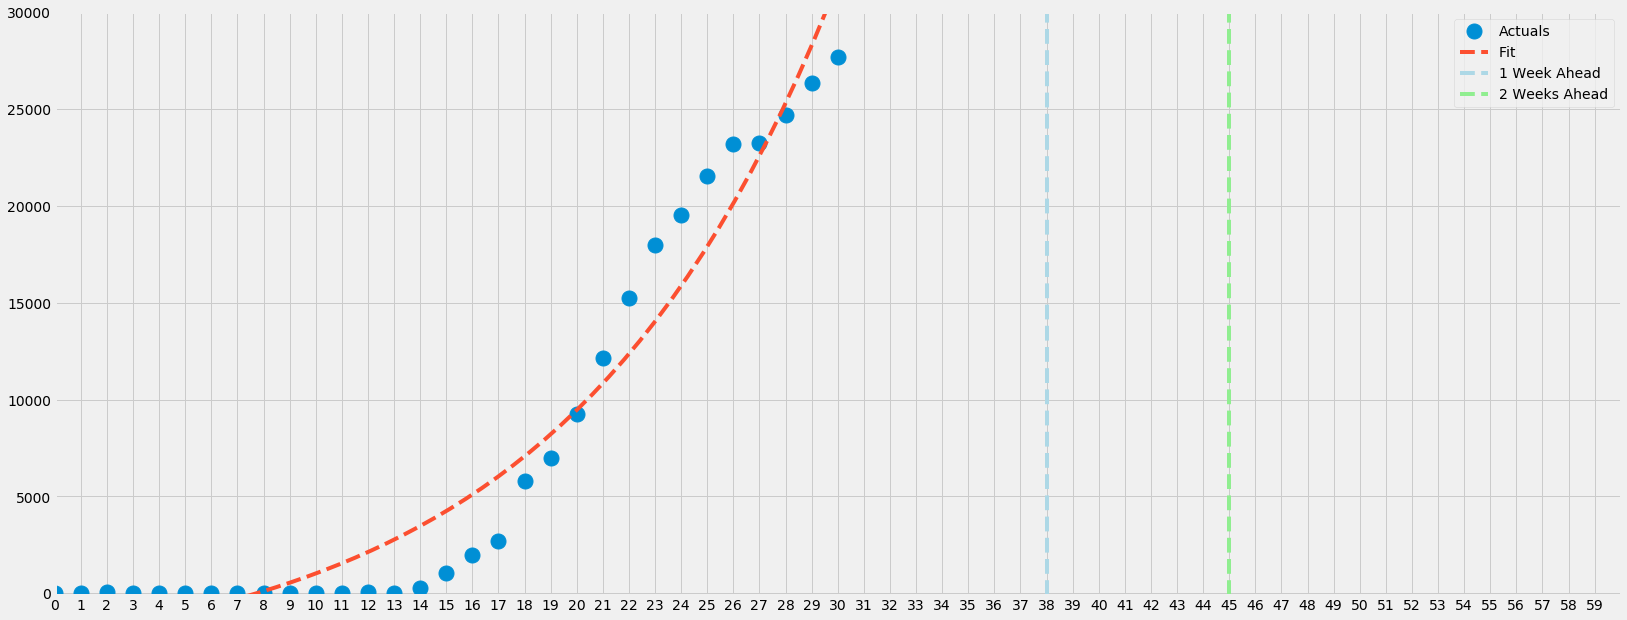

In [14]:
# test_data = 1
points = 0
length = df_sc.count()
n = length - points
print('Suspected CASES')
print('***************')
sm.proj(df_sc,n,600000)
print('Suspected CASES')
print('***************')
sm.proj(df_sc,n,150000)
print('Suspected CASES')
print('***************')
sm.proj(df_sc,n,30000)

Daily New Cases & Fatalities


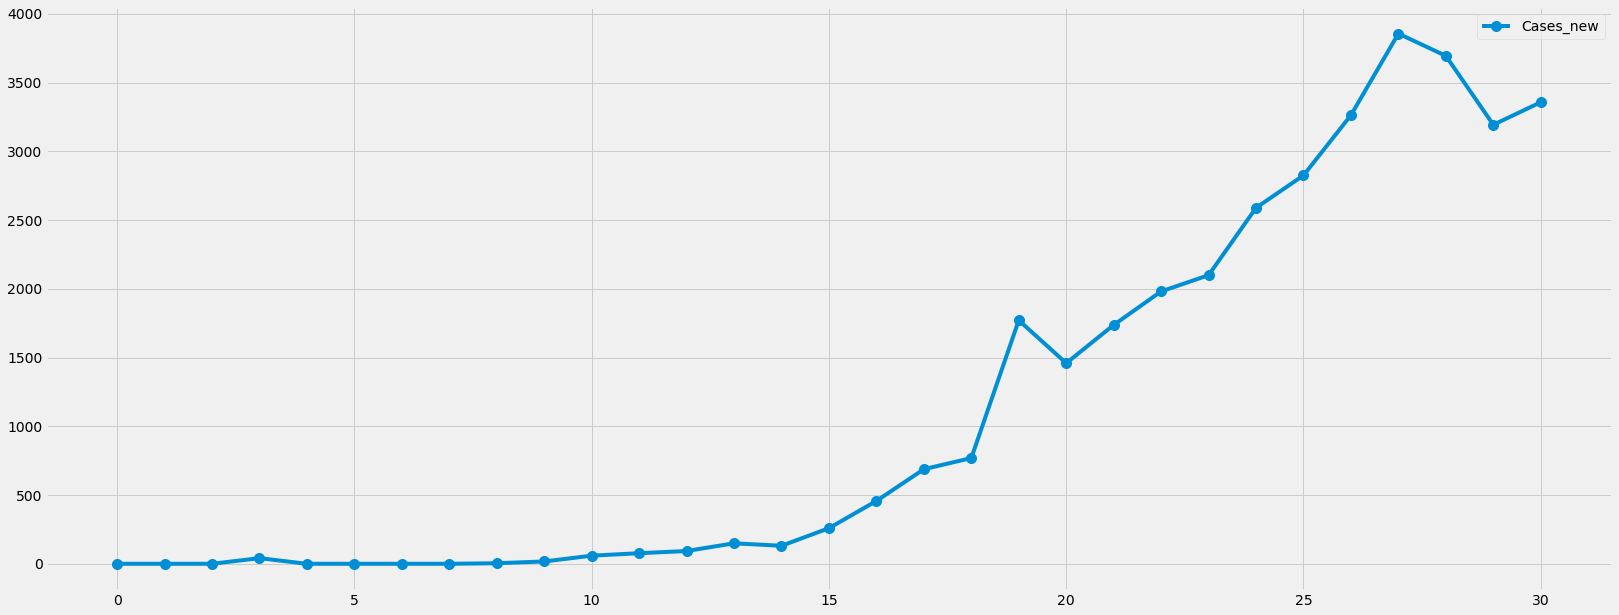

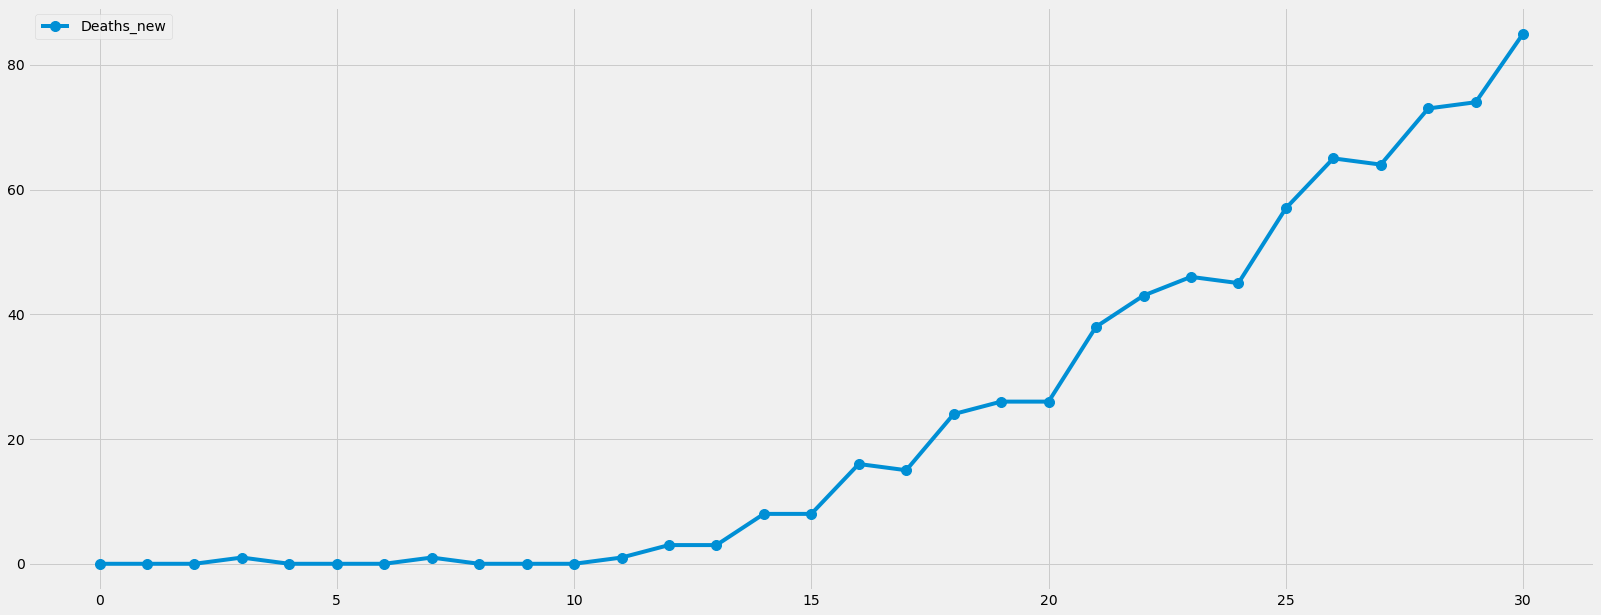

In [15]:
df=df.fillna(0)
df_cp = df['Cases_pct']
df_cn = df['Cases_new']
df_dp = df['Deaths_pct']
df_dn = df['Deaths_new']
print('Daily New Cases & Fatalities')

rcParams['figure.figsize'] = 25,10
df['Cases_new'].plot(marker='o', markersize = 10)
plt.legend()
plt.show()
df['Deaths_new'].plot(marker='o', markersize = 10)
plt.legend()
plt.show()

DAILY NEW CASES
***************
a =  425.1134649719689
b =  0.08133058350559282
c =  -737.1175045617555
R^2 = 0.9322
Next predicted data point   4,553
         7 Days from Now    8,611
        14 Days from Now    15,781


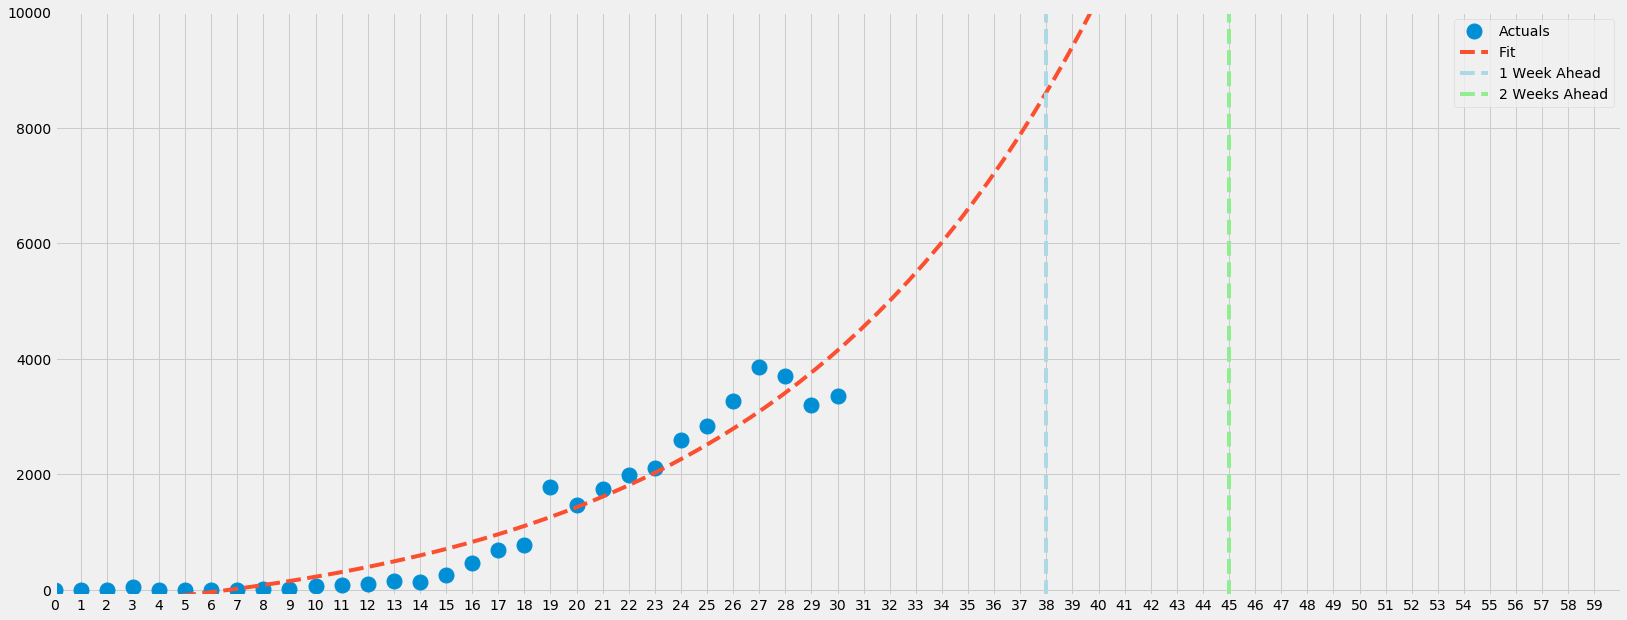

DAILY NEW CASES
***************
a =  425.1134649719689
b =  0.08133058350559282
c =  -737.1175045617555
R^2 = 0.9322
Next predicted data point   4,553
         7 Days from Now    8,611
        14 Days from Now    15,781


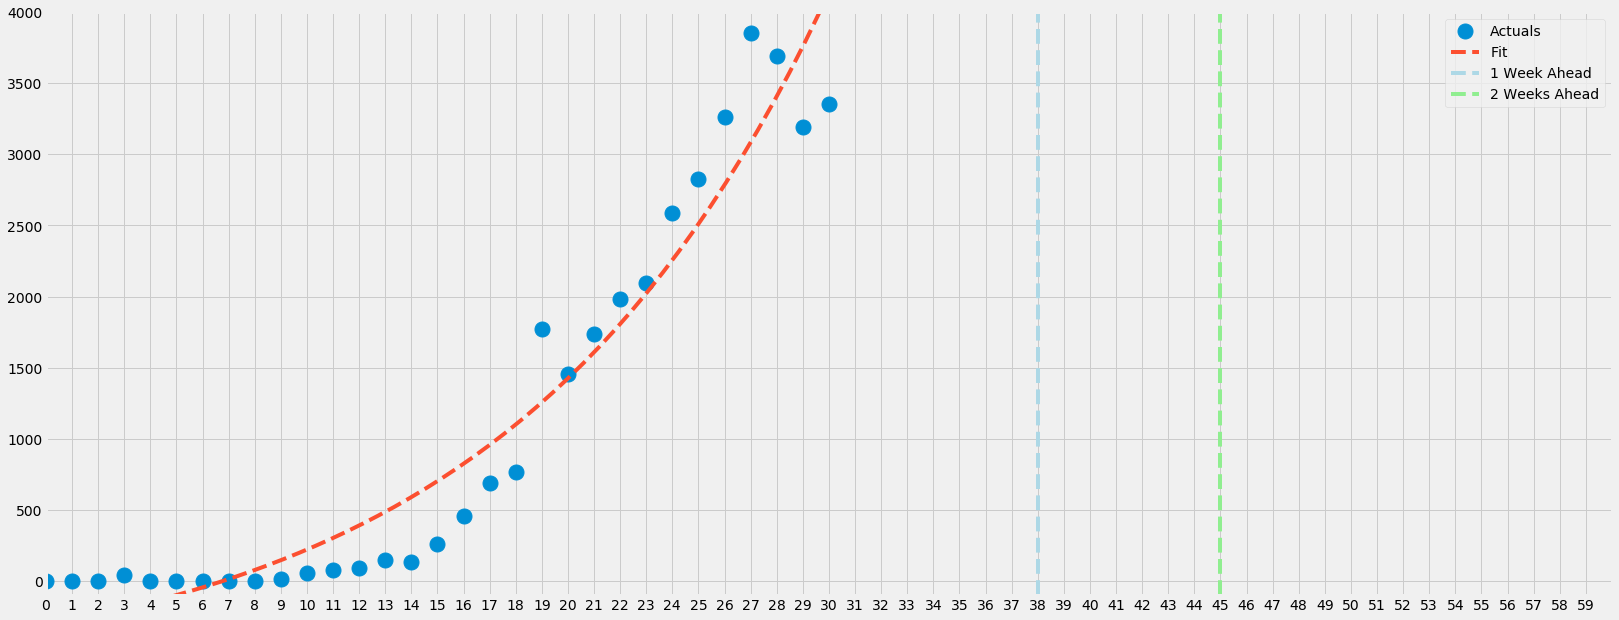

In [16]:
# test_data = 1
points = 0
length = df_cn.count()
n = length - points
print('DAILY NEW CASES')
print('***************')
sm.proj(df_cn,n,10000)

print('DAILY NEW CASES')
print('***************')
sm.proj(df_cn,n,4000)

DAILY NEW FATALITIES
***************
a =  6.231874394555358
b =  0.09252596038367955
c =  -11.147977530771518
R^2 = 0.9778
Next predicted data point   99
         7 Days from Now    199
        14 Days from Now    390


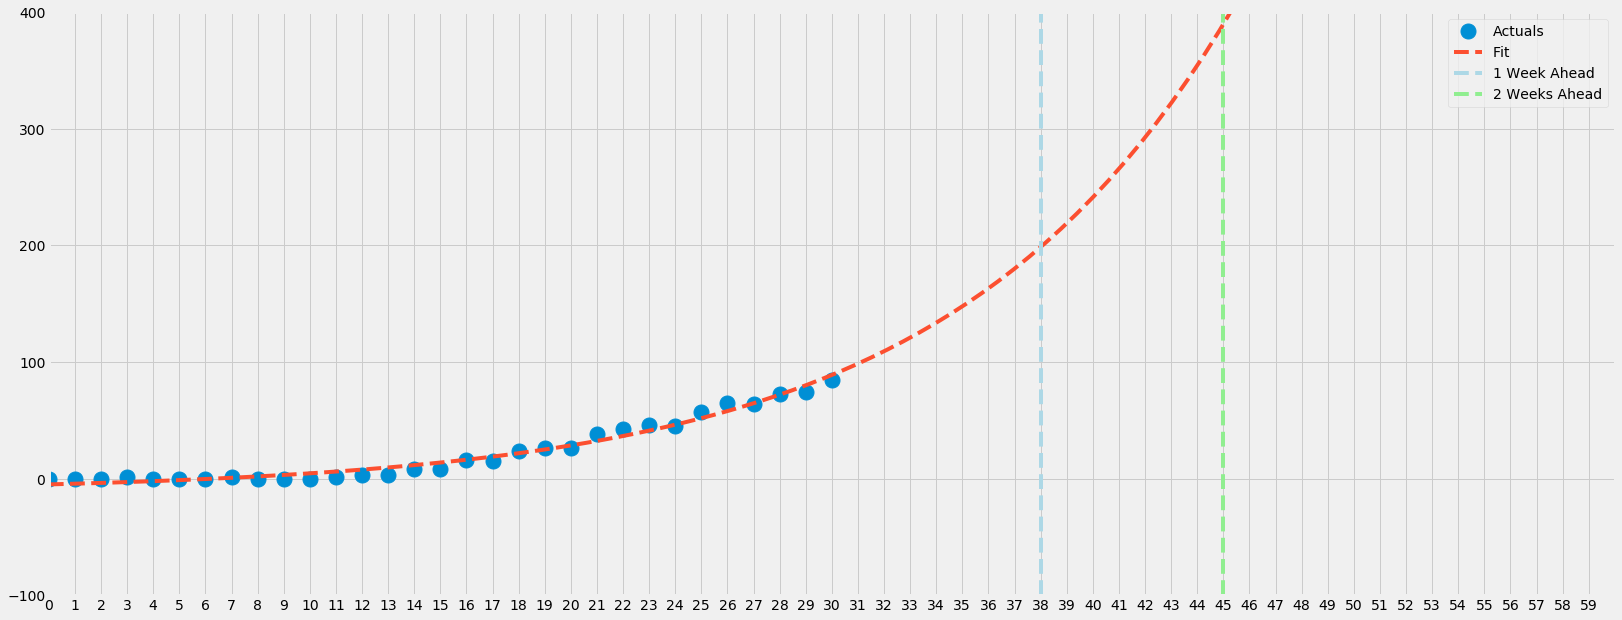

DAILY NEW FATALITIES
***************
a =  6.231874394555358
b =  0.09252596038367955
c =  -11.147977530771518
R^2 = 0.9778
Next predicted data point   99
         7 Days from Now    199
        14 Days from Now    390


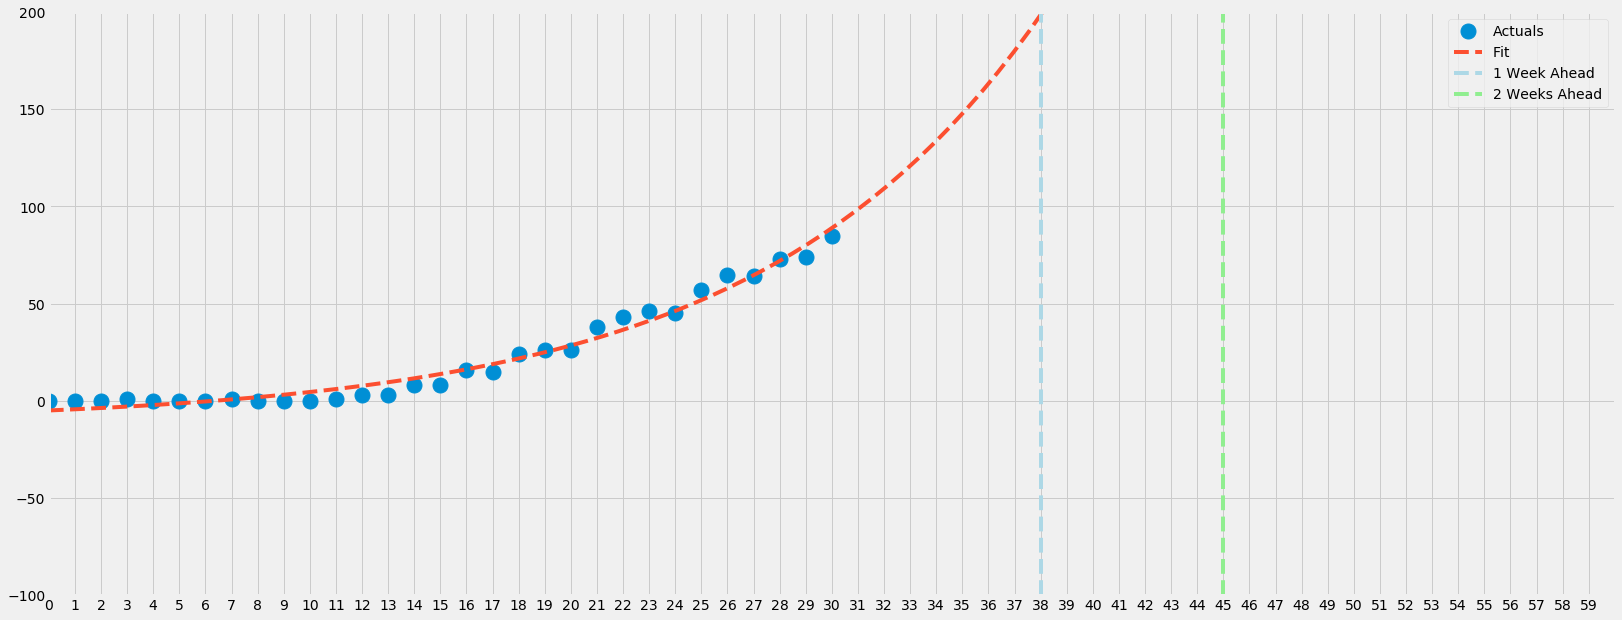

In [17]:
# test_data = 1
points = 0
length = df_dn.count()
n = length - points
print('DAILY NEW FATALITIES')
print('***************')
sm.proj(df_dn,n,400)
print('DAILY NEW FATALITIES')
print('***************')
sm.proj(df_dn,n,200)

CONFIRMED CASES
***************
a =  335.0675083751645
b =  0.15808459873225678
c =  -1364.8046728534177
R^2 = 0.9897
Next predicted data point   43,659
         7 Days from Now    134,790
        14 Days from Now    410,372


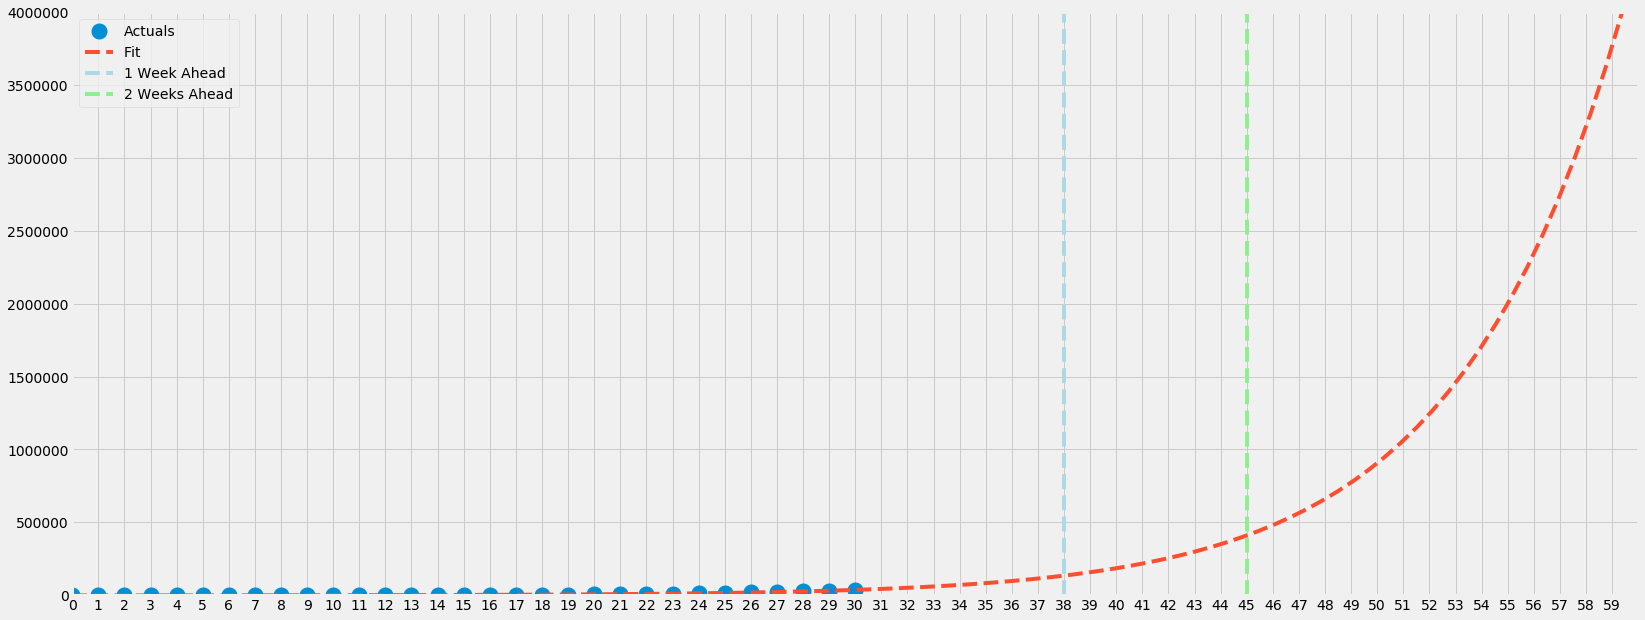

CONFIRMED CASES
***************
a =  335.0675083751645
b =  0.15808459873225678
c =  -1364.8046728534177
R^2 = 0.9897
Next predicted data point   43,659
         7 Days from Now    134,790
        14 Days from Now    410,372


CONFIRMED CASES
***************
a =  335.0675083751645
b =  0.15808459873225678
c =  -1364.8046728534177
R^2 = 0.9897
Next predicted data point   43,659
         7 Days from Now    134,790
        14 Days from Now    410,372


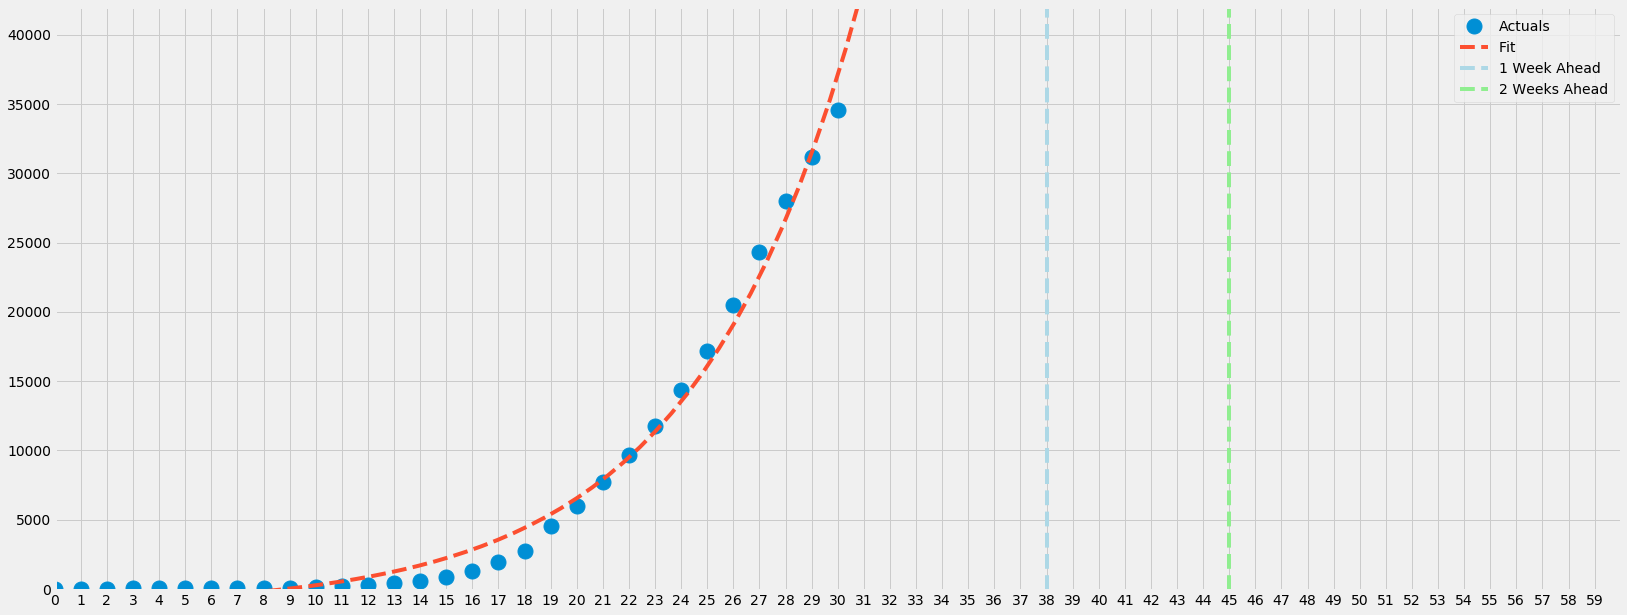

In [18]:
# test_data = 1
points = 0
length = df_cc.count()
n = length - points
print('CONFIRMED CASES')
print('***************')
sm.proj(df_cc,n)
#Zoom-in
print('CONFIRMED CASES')
print('***************')
sm.proj(df_cc,n,500000)
print('CONFIRMED CASES')
print('***************')
sm.proj(df_cc,n,42000)

CONFIRMED CASES outside Mainland China
**************************************


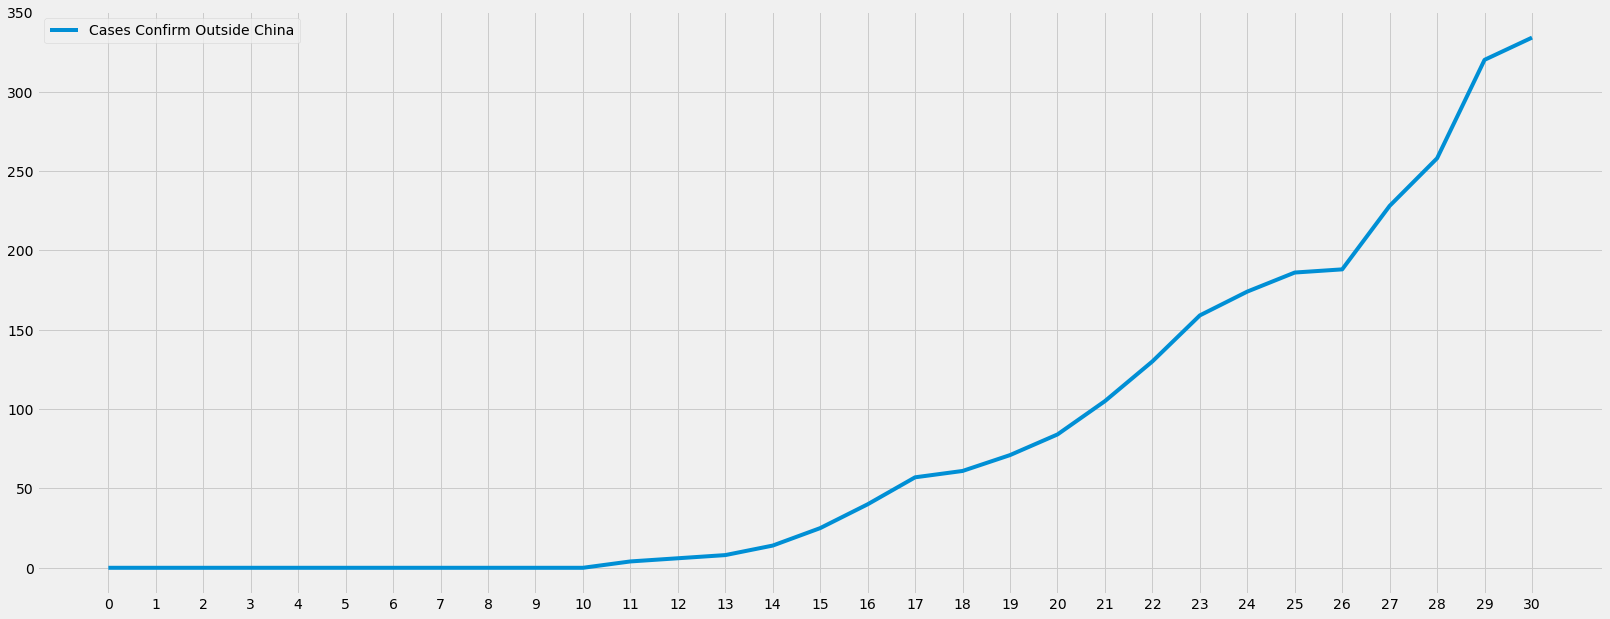

In [19]:
print('CONFIRMED CASES outside Mainland China')
print('**************************************')
df_cco.plot(xticks=df.index)
plt.legend()
plt.show()

CONFIRMED CASES outside Mainland China - Exponential Model
**********************************************************
a =  9.375006224430855
b =  0.12239270595992217
c =  -21.807821238701244
R^2 = 0.9884
Next predicted data point   395
         7 Days from Now    960
        14 Days from Now    2,290


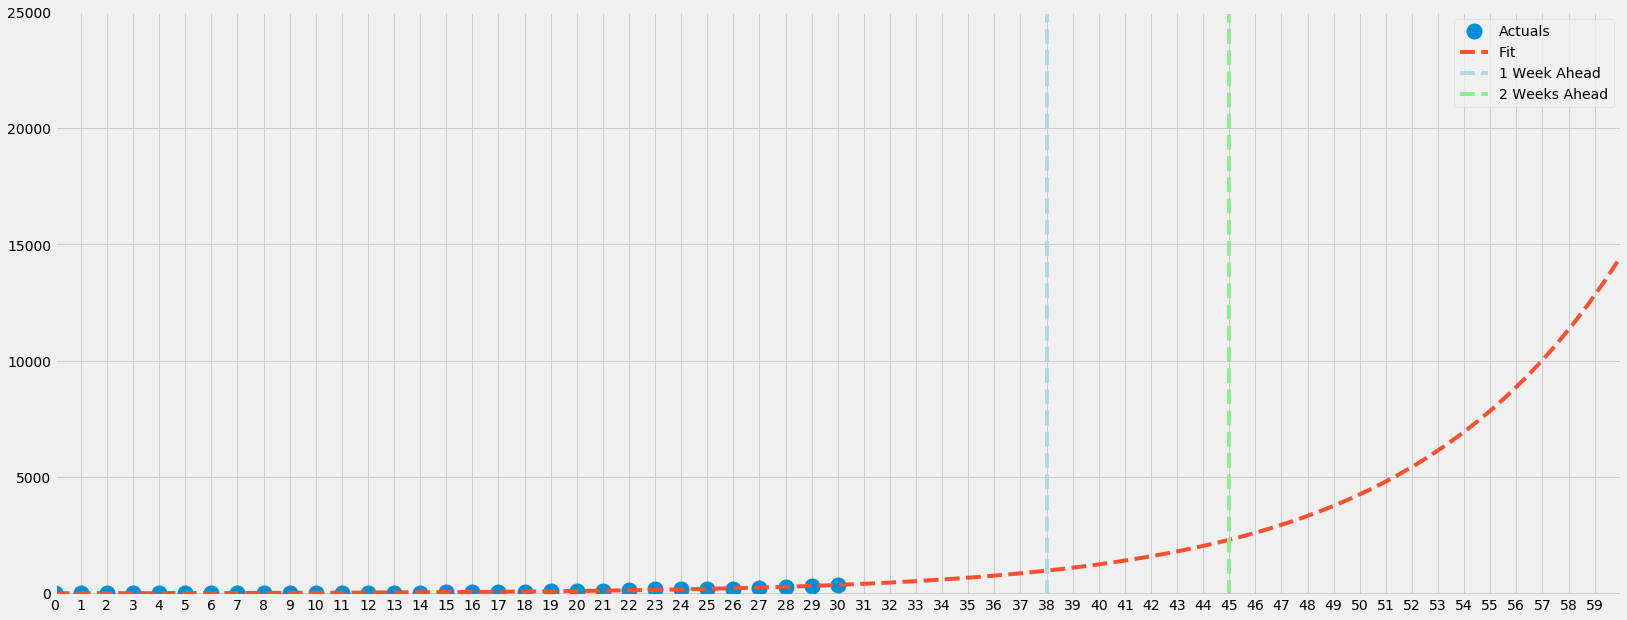

CONFIRMED CASES outside Mainland China - Exponential Model
**********************************************************
a =  9.375006224430855
b =  0.12239270595992217
c =  -21.807821238701244
R^2 = 0.9884
Next predicted data point   395
         7 Days from Now    960
        14 Days from Now    2,290


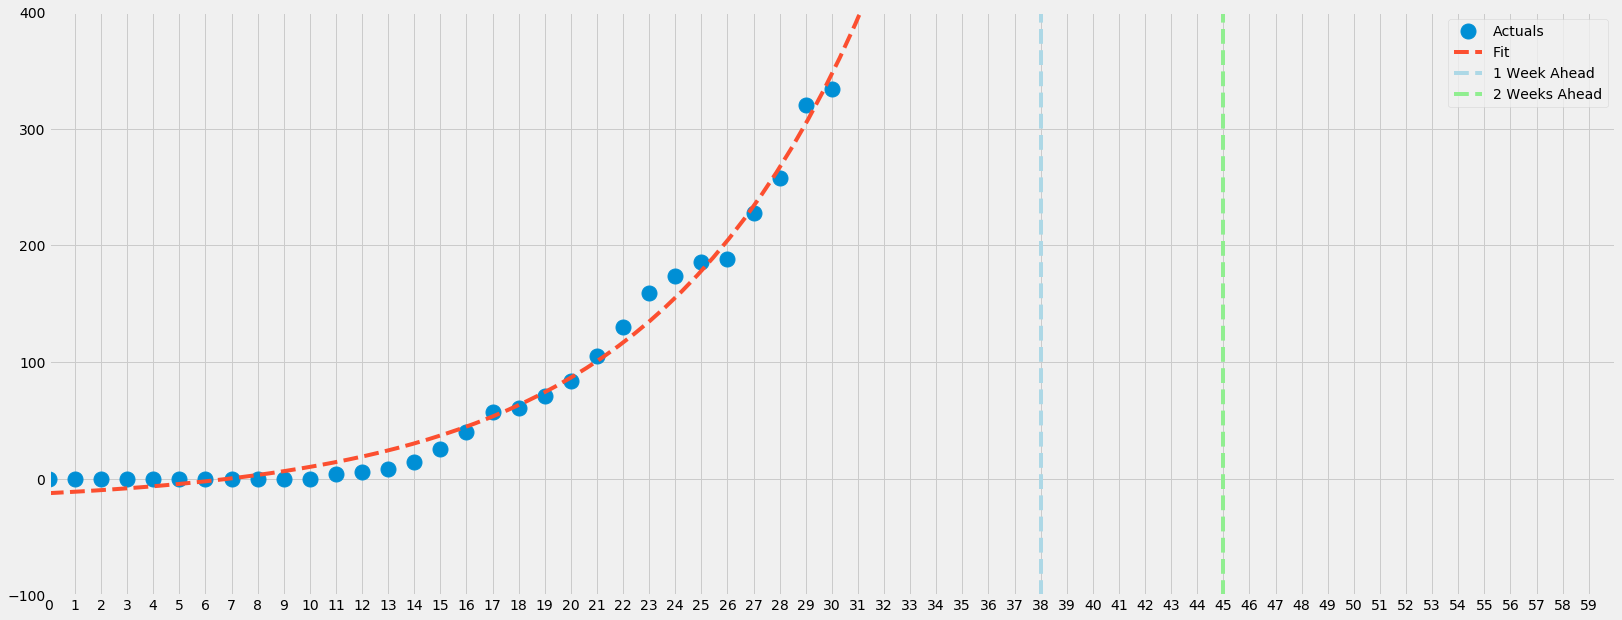

In [20]:
df_cco=df_cco.fillna(0)
# test_data = 1
points = 0
length = df_cco.count()
n = length - points
print('CONFIRMED CASES outside Mainland China - Exponential Model')
print('**********************************************************')
sm.proj(df_cco,n,25000)
print('CONFIRMED CASES outside Mainland China - Exponential Model')
print('**********************************************************')
sm.proj(df_cco,n,400)

RECOVERIES vs. FATALITIES Outside of China


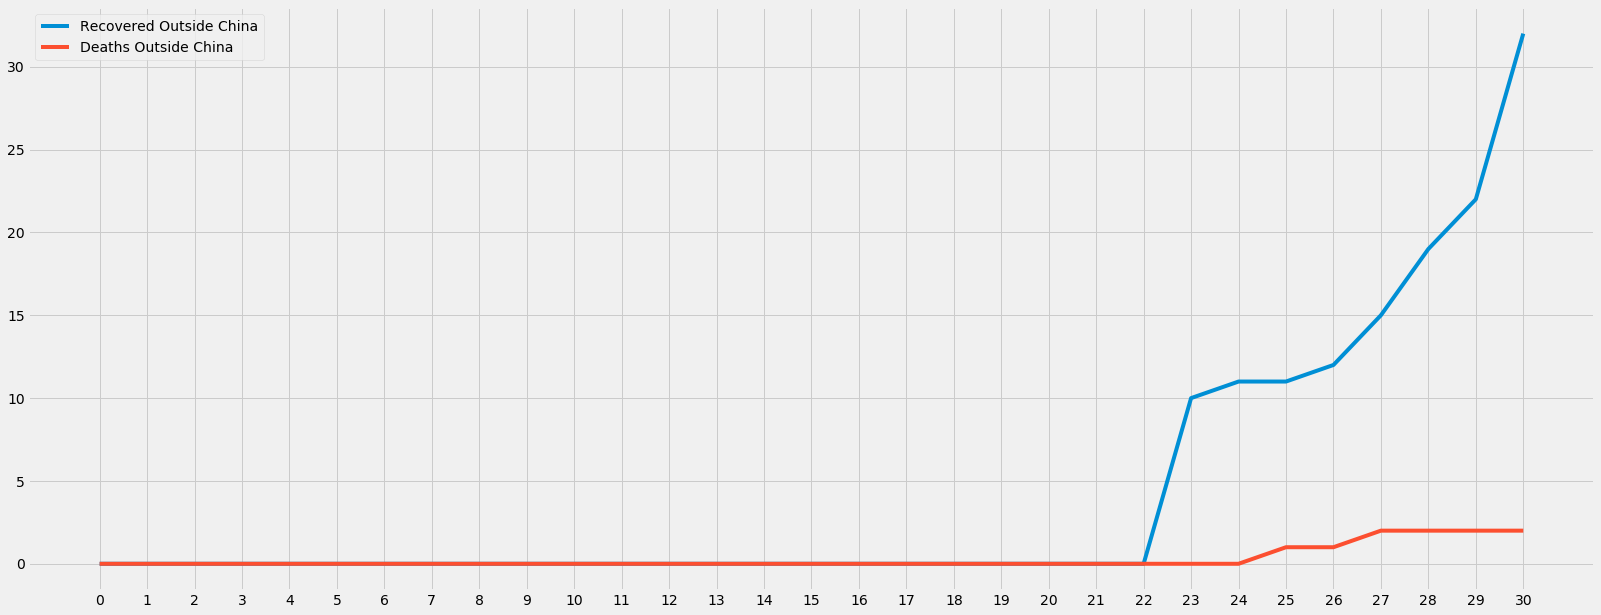

In [21]:
df_do = df['Deaths Outside China']
df_ro = df['Recovered Outside China']
print('RECOVERIES vs. FATALITIES Outside of China')
df_ro.plot(xticks=df.index)
df_do.plot(xticks=df.index)
plt.legend()
plt.show()

FATALITIES
**********
a =  8.27858978414695
b =  0.15172990921788584
c =  -28.804111764183684
R^2 = 0.9931
Next predicted data point   885
         7 Days from Now    2,614
        14 Days from Now    7,614


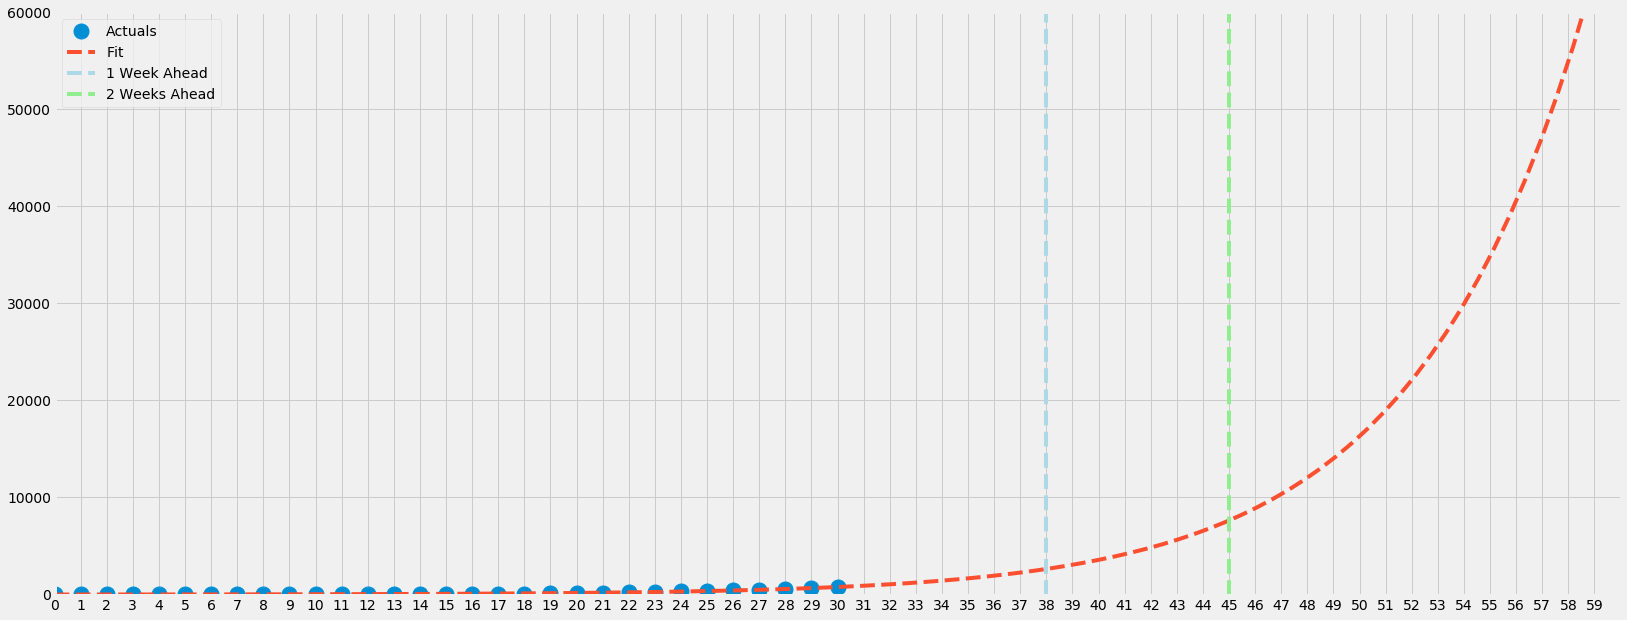

FATALITIES
**********
a =  8.27858978414695
b =  0.15172990921788584
c =  -28.804111764183684
R^2 = 0.9931
Next predicted data point   885
         7 Days from Now    2,614
        14 Days from Now    7,614


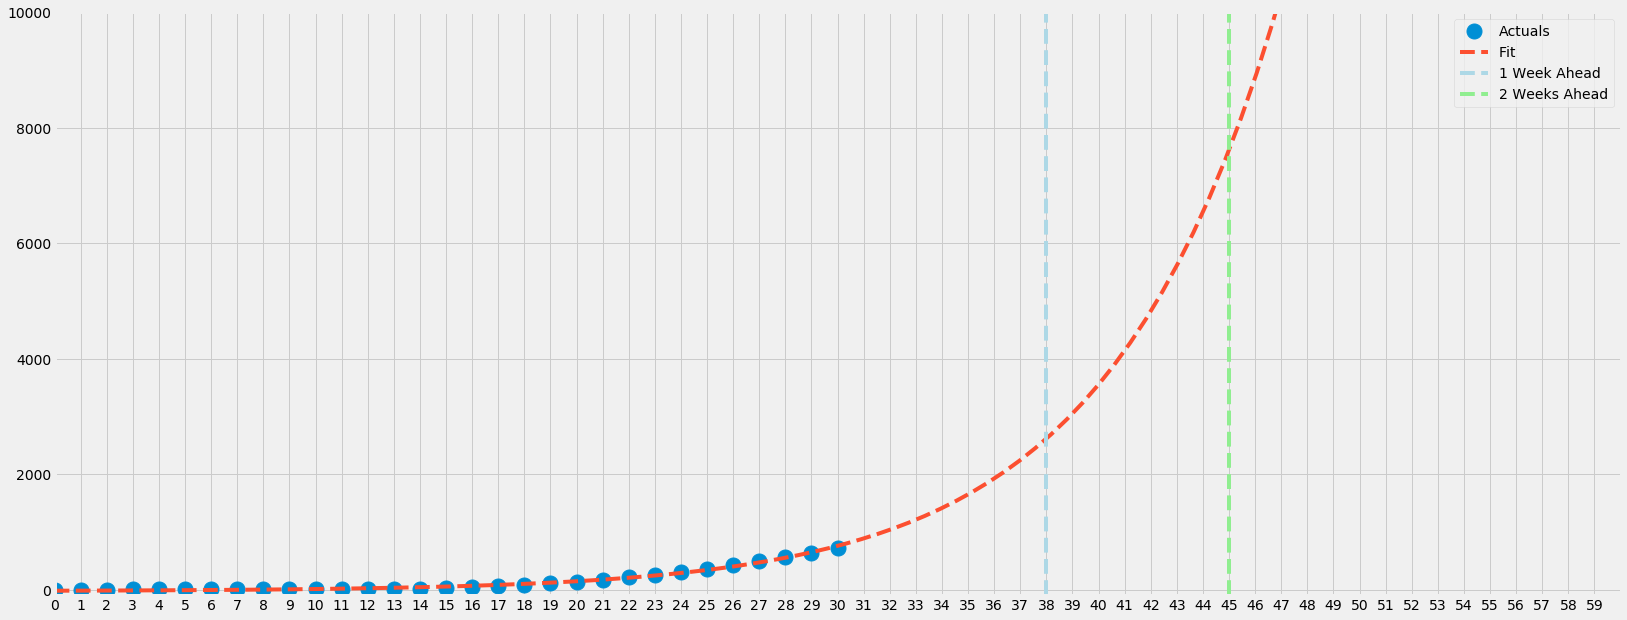

FATALITIES
**********
a =  8.27858978414695
b =  0.15172990921788584
c =  -28.804111764183684
R^2 = 0.9931
Next predicted data point   885
         7 Days from Now    2,614
        14 Days from Now    7,614


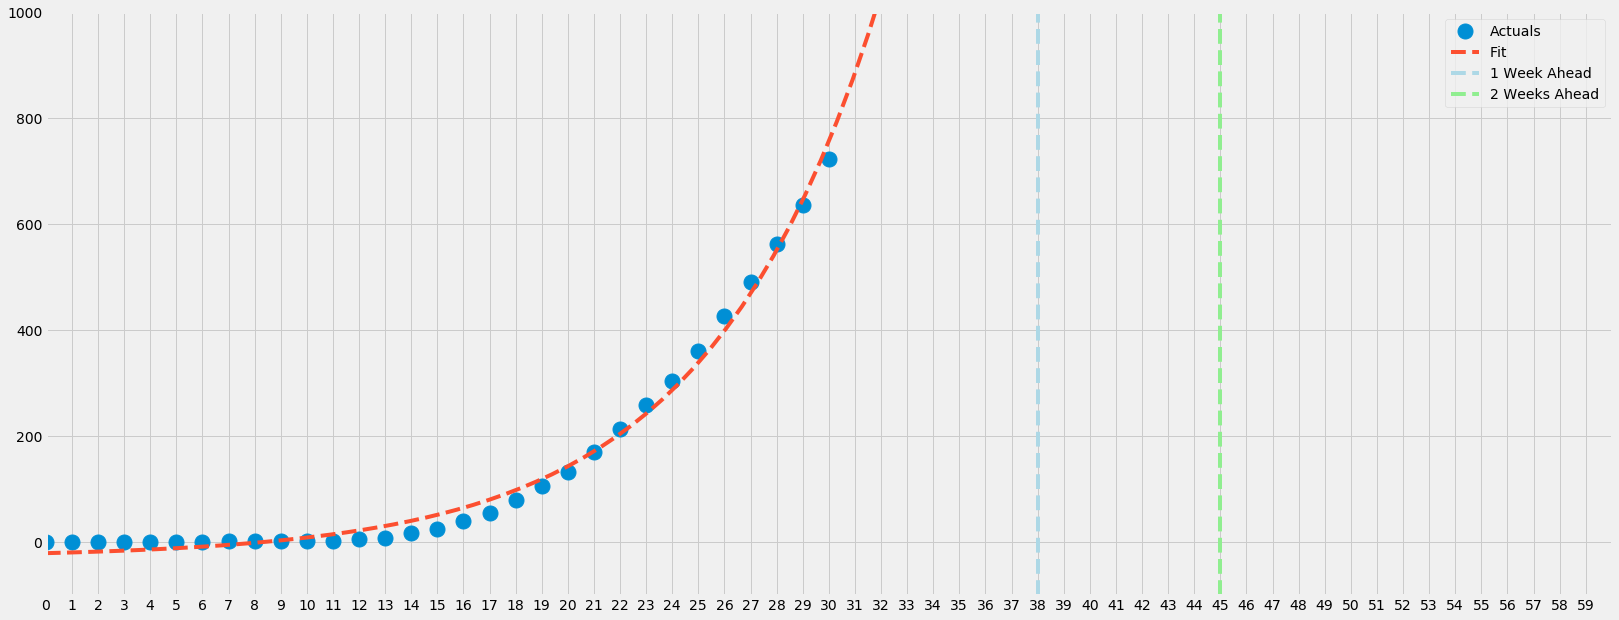

In [22]:
# test_data = 1
points = 0
length = df_d.count()
print('FATALITIES')
print('**********')
n = length - points
sm.proj(df_d,n, 60000)
print('FATALITIES')
print('**********')
sm.proj(df_d,n, 10000)
print('FATALITIES')
print('**********')
sm.proj(df_d,n, 1000)

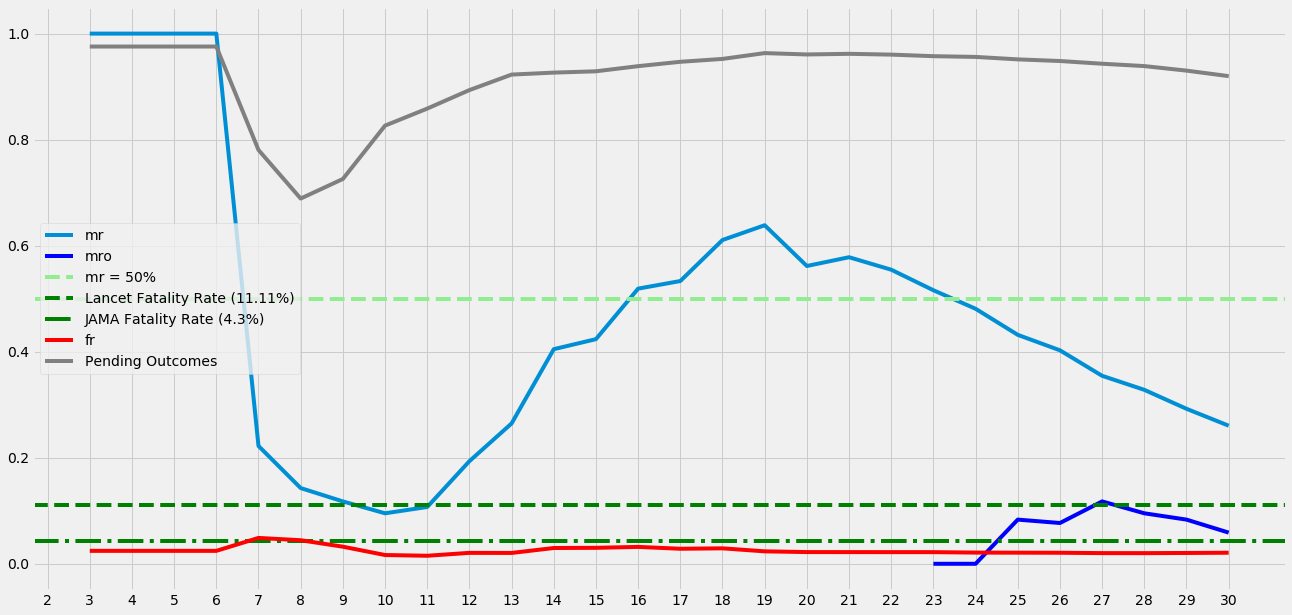

Estimating future fatalities using various rates based on insights from the data
Outcomes Pending in China = 92%
MR Based Fatalities =     9,004
Lancet Based Fatalities = 3,841
MRO Based::        China = 2,033
JAMA Based Fatalities    = 1,486
MRO Based::Outside China = 20
JAMA Based Fatalities    = 14
Current:                       FR  =  2%
                               MR  = 26%
                               MRO = 6%
Reference [RED Dot] from Lancet Study 11%
Reference [Green Dot] from JAMA Paper 4%


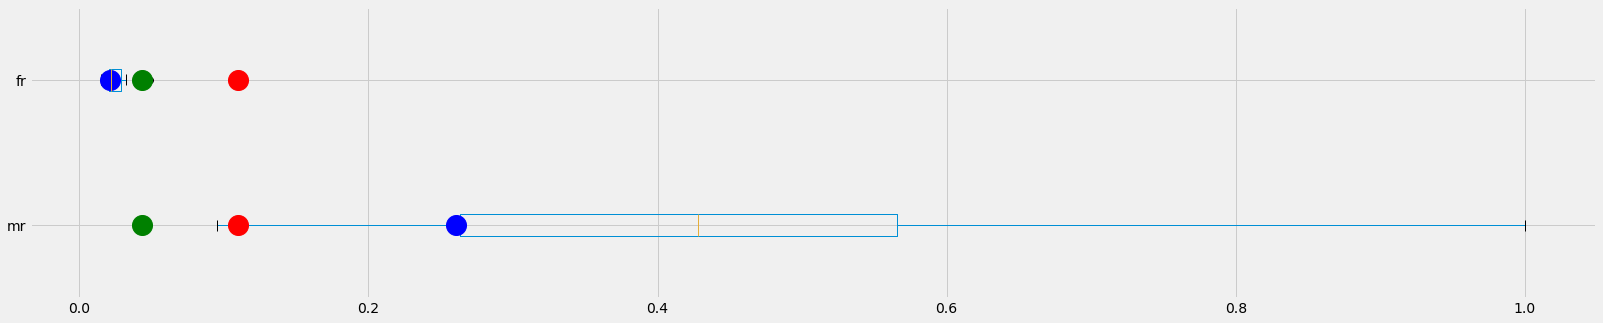

In [23]:
# MR % = Fatalities / (Fatalities + Recovered)
rcParams['figure.figsize'] = 20,10

df['mr'] = df.Deaths/(df.Deaths + df.Recovered)
df.mr.plot()
df['mro'] = df['Deaths Outside China']/(df['Deaths Outside China'] + df['Recovered Outside China'])
df.mro.plot(color='b')

# FR % = Fatalities / Confirmed Cases
df['fr'] = df.Deaths/(df['Cases Confirmed'])
plt.axhline(y=0.5, color='lightgreen', linestyle='--', label = 'mr = 50%')
plt.axhline(y=11/99, color='green', linestyle='--', label = 'Lancet Fatality Rate (11.11%)')
plt.axhline(y=4.3/100, color='green', linestyle='-.', label = 'JAMA Fatality Rate (4.3%)')
df.fr.plot(xticks=df.index, color='r')

#Pending Outcomes
df['po'] = (df['Cases Confirmed'] - df['Deaths'] - df['Recovered'])/df['Cases Confirmed'] 
df['po'].plot(color='grey', label = 'Pending Outcomes')

plt.legend()
plt.show()

print('Estimating future fatalities using various rates based on insights from the data')
print('Outcomes Pending in China = {:0.0%}'.format(df.po.tail(1).values[0]))
print('MR Based Fatalities =     {:,.0f}'.format(df_cc.tail(1).values[0]*df.mr.tail(1).values[0]))
print('Lancet Based Fatalities = {:,.0f}'.format(df_cc.tail(1).values[0]*11/99))
print('MRO Based::        China = {:,.0f}'.format(df_cc.tail(1).values[0]*df.mro.tail(1).values[0]))
print('JAMA Based Fatalities    = {:,.0f}'.format(df_cc.tail(1).values[0]*4.3/100))
print('MRO Based::Outside China = {:,.0f}'.format(df_cco.tail(1).values[0]*df.mro.tail(1).values[0]))
print('JAMA Based Fatalities    = {:,.0f}'.format(df_cco.tail(1).values[0]*4.3/100))

b=df.fr[len(df)-1]
print('Current:                       FR  =  {:.0%}'.format(b))
a=df.mr[len(df)-1]
print('                               MR  = {:.0%}'.format(a))
print('                               MRO = {:,.0%}'.format(df.mro.tail(1).values[0]))
print('Reference [RED Dot] from Lancet Study {:.0%}'.format(11/99))
print('Reference [Green Dot] from JAMA Paper {:.0%}'.format(.043))

#Boxplots
rcParams['figure.figsize'] = 25,5
df.boxplot(column=['mr','fr'], vert = False)
plt.plot(a, [1], marker='o', markersize=20, color="blue")
plt.plot(b, [2], marker='o', markersize=20, color="blue")
plt.plot(.11, [1], marker='o', markersize=20, color="Red")
plt.plot(.11, [2], marker='o', markersize=20, color="Red")
plt.plot(.043, [1], marker='o', markersize=20, color="Green")
plt.plot(.043, [2], marker='o', markersize=20, color="Green")
plt.show()

Reference Rates: https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates

<b>Tableau Charts</b><br>
Tableau Charts and Forecasts built using Tableau are available on the URL:<br>
https://public.tableau.com/profile/sm.tx#!/vizhome/nCov19-v2/CasesnFatalitiesDailyDelta <br>
The built-in forecasting algorithms in Tableau Public are fairly simple and less accurate than SciPy. 